In [ ]:
# импорт специально написанных инструментов для взлома шифра
from tools import VigenereLengthFinder, VigenereCracker
# также подгружаем остальные необходимые питоновские библиотеки
import matplotlib.pyplot as plt
import pandas as pd

Для того, чтобы взломать шифр Виженера, нужна сначала попытаться определить длину ключа. Для этого используется метод индекса совпадений
> Метод основан на том факте, что вероятность совпадения двух случайных букв в некотором достаточно длинном тексте (индекс совпадений) — это постоянная величина. Таким образом, если разбить текст на L групп символов, каждая из которых зашифрована шифром простой замены (напомню, это и означает, что L — длина ключевого слова), то индексы совпадений для каждой из групп будут довольно близки к теоретическому значению этой величины; для всех других разбиений индексы совпадений будут гораздо ниже. 

$$ИС = \sum_{i} \dfrac{f_i \left( f_i - 1 \right)}{n\left(n - 1 \right)} $$
Здесь $f_i$ - количество i-х букв алфавита в тексте, а $n$ — его длина

In [2]:
# читаем зашифрованный файл
with open('materials/2024_11_29_19_46_57_Виктор_Ушков_task.txt', 'r', encoding="utf-8") as f:
    text = f.read()
# создаем экземпляр класса VigenereLengthFinder для определения длины ключа (реализация в файле tools.py)
vlf = VigenereLengthFinder(encrypted_text=text)
ICs = vlf.all_lengths_ICs

Построим барплот полученных индексов совпадений для рассматриваемых длин ключа

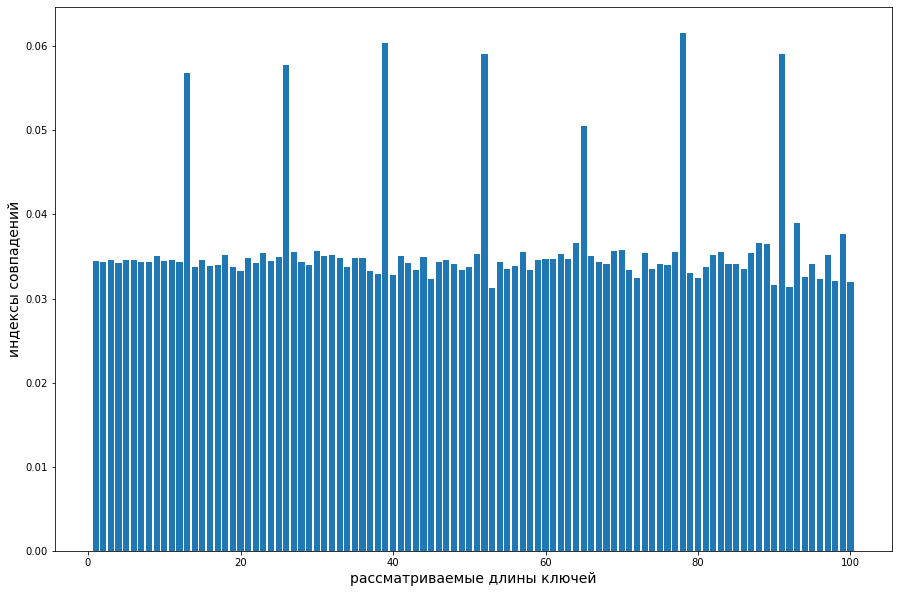

In [3]:
plt.figure(figsize=(15,10))
plt.bar(ICs.keys(), ICs.values())
plt.xlabel("рассматриваемые длины ключей", fontsize=14)
plt.ylabel("индексы совпадений", fontsize=14)
plt.show()

Пики барплота находятся на длинах ключа, кратных числу 13. 
В первую очередь предположим, что ключ состоит из 13 символов

Для дальнейшей работы загрузим словарь слов русского языка - данный словарь был взят с репозитория https://github.com/danakt/russian-words

В этом словаре содержится больше 1 500 000 записей, слова содержатся во всех морфологических формах, поэтому покрытие будет достаточно большим

Также приведем слова в словаре к виду, в котором слова представлены в зашифрованном тексте - то есть приведем к верхнему регистру

In [4]:
# загружаем список слов русского языка
with open("materials/russian.txt") as f:
    vocabulary = f.readlines()

# предобработка
words = [str.upper(word.strip()) for word in vocabulary]
print(words[:10])
print(words[-10:])

['-ДЕ', '-КА', '-ЛИБО', '-НИБУДЬ', '-С', '-ТАКИ', '-ТО', 'А', 'А-КОНТО', 'А-ЛЯ']
['ПОСМУРНЕВШАЯ', 'ПОСМУРНЕВШЕГО', 'ПОСМУРНЕВШЕЕ', 'ПОСМУРНЕВШЕЙ', 'ПОСМУРНЕВШЕМ', 'ПОСМУРНЕВШЕМУ', 'ПОСМУРНЕВШЕЮ', 'ПОСМУРНЕВШИ', 'ПОСМУРНЕВШИЕ', 'ПОСМУРНЕВШИЙ']


Для удобства создадим словарь, в котором ключами будут длины слов, а значениями - список слов длиной, соответствующей ключу

In [5]:
dict_by_lengths = {i: [] for i in range(1, len(max(words, key=len)) + 1)}
for word in words:
    #не заносим слова с дефисом
    if "-" in word:
        continue
    dict_by_lengths[len(word)].append(word)

Теперь, с помощью написанного класса для взлома шифра, попытаемся получить оригинальный текст. Для этого будем использовать способ перебора сдвигов по частотам, способ реализован в файле tools.py в классе VigenereCracker

In [6]:
# создаем экземпляр класса VigenereCracker для поиска ключа путем перебора сдвигов по частотам (реализация в файле tools.py)
vc = VigenereCracker(text, 13)
# limit - количество слов на котором проверяется корректность расшифрованного текста
# error_threshold - максимально допустимое отношение количества слов, которые не были найдены в словаре dict_by_lengths к количеству всех проверяемых слов (limit)
# для экономии времени, функция вернет первый текст, удовлетворяемый error_threshold 
# (90% корректных слов достаточный порог, чтобы найти хотя бы один такой текст, но при этом высокий, чтобы удовлетворяющих текстов было больше одного)
original_text = vc.decrypt_text(limit=100, words_by_length=dict_by_lengths, error_threshold=0.1)

In [7]:
for item in original_text.values():
    print(item, '\n')

ОСТАЛСЯ КУСОЧЕК ЛУНЫ, ТО ЕСТЬ ТОТ ЛУННЫЙ КАМЕНЬ, КОТОРЫЙ ОН ОТБИЛ МОЛОТКОМ ОТ СКАЛЫ, КОГДА ОПУСКАЛСЯ С ФУКСИЕЙ И СЕЛЁДОЧКОЙ В ЛУННУЮ ПЕЩЕРУ. ЭТОТ ЛУННЫЙ КАМЕНЬ, ИЛИ ЛУНИТ, КАК ЕГО НАЗЫВАЛ ЗНАЙКА, ЛЕЖАЛ У НЕГО В КОМНАТЕ НА ПОДОКОННИКЕ И ПОМИНУТНО ПОПАДАЛСЯ НА ГЛАЗА. ВЗГЛЯНУВ НА ЛУНИТ, ЗНАЙКА ТОТЧАС ЖЕ ВСПОМИНАЛ О ЛУНЕ И ОБО ВСЁМ, ЧТО ПРОИЗОШЛО, И СНОВА РАССТРАИВАЛСЯ.

ОДНАЖДЫ, ПРОСНУВШИСЬ НОЧЬЮ, ЗНАЙКА ВЗГЛЯНУЛ НА ЛУНИТ, И ЕМУ ПОКАЗАЛОСЬ, ЧТО КАМЕНЬ В ТЕМНОТЕ СВЕТИТСЯ КАКИМ-ТО МЯГКИМ ГОЛУБОВАТЫМ СВЕТОМ. УДИВЛЁННЫЙ ЭТИМ НЕОБЫЧНЫМ ЯВЛЕНИЕМ, ЗНАЙКА ВСТАЛ С ПОСТЕЛИ И ПОДОШЁЛ К ОКОШКУ, ЧТОБ РАССМОТРЕТЬ ЛУННЫЙ КАМЕНЬ ВБЛИЗИ. ТУТ ОН ЗАМЕТИЛ, ЧТО НА НЕБЕ БЫЛА ПОЛНАЯ, ЯРКАЯ ЛУНА. ЛУЧИ ОТ ЛУНЫ ПАДАЛИ ПРЯМО В ОКНО И ОСВЕЩАЛИ КАМЕНЬ ТАК, ЧТО СОЗДАВАЛОСЬ ВПЕЧАТЛЕНИЕ, БУДТО ОН СВЕТИЛСЯ САМ СОБОЙ. ПОЛЮБОВАВШИСЬ ЭТИМ КРАСИВЫМ ЗРЕЛИЩЕМ, ЗНАЙКА УСПОКОИЛСЯ И ЛЁГ В ПОСТЕЛЬ.





В ДРУГОЙ РАЗ (ЭТО СЛУЧИЛОСЬ ВЕЧЕРОМ) ЗНАЙКА ДОЛГО СИДЕЛ ЗА КНИЖКОЙ, А КОГДА НАКОНЕЦ РЕШИЛ ЛЕЧЬ СПАТЬ, БЫЛА УЖЕ ГЛУБОКАЯ НОЧЬ. РАЗ

Путем перебора сдвигов по частотам был получен оригинальный текст - отрывок из произведения "Незнайка на Луне"

Ключом оказалось словосочетание "ЗЕЛЁНОЕЯБЛОКО"